# Library

In [ ]:
import numpy as np

from PIL import Image

import json

from tqdm import tqdm

import pandas as pd

import pickle

import cv2

import os

import glob

import tensorflow as tf

import keras

import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

#  Image Preprocessing

## Load image

In [ ]:
total_data_dic = {
    'file_name' : [],
    'sex' : [],
    'age' : [],
    'face_type' : [],
    'hairstyle' : [],
    'image' : []
}

for i in tqdm(range(13343)): #학습 13342 검증 35802
  
  file_dir = f'./{i}.png' # 학습
  
  if not os.path.isfile(file_dir):
    continue
  
  img = Image.open(file_dir)

  with open(f'./{i}.json', 'r', encoding="utf-8") as json_file:  # 학습
    json_data = json.load(json_file)


  scalar = np.array(img)

  total_data_dic['file_name'].append(json_data['info'][0]['org_img_name'])
  total_data_dic['sex'].append(json_data['info'][0]['gender'])
  total_data_dic['age'].append(json_data['info'][0]['age'])
  total_data_dic['face_type'].append(json_data['descripton'][0]['face']['type'])
  total_data_dic['hairstyle'].append(json_data['descripton'][0]["hairstyle"]['type'])
  total_data_dic['image'].append(scalar)



df_face_data = pd.DataFrame(total_data_dic)

display(df_face_data)

100%|██████████| 13343/13343 [01:25<00:00, 156.22it/s] 


,file_name,sex,age,face_type,hairstyle,image
0,20,M,20,둥근형,직모(생머리),"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,21,M,20,긴형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,22,M,20,사각형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,23,M,20,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,24,M,20,계란형,스포츠형,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...,...,...,...,...
8066,13338,F,56,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
8067,13339,F,56,계란형,웨이브형,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
8068,13340,F,56,긴형,웨이브형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
8069,13341,F,56,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


## Resize image

In [ ]:
for i in tqdm(range(13343)): #학습 13342 검증 35802
  
    file_dir = f'./{i}.png' # 학습

    if not os.path.isfile(file_dir):
        continue

    img = cv2.imread(file_dir)

        # 이미지의 x, y가 224이 넘을 경우 작게해주기
        percent = 1
        if(img.shape[1] > img.shape[0]) :       # 이미지의 가로가 세로보다 크면 가로를 640으로 맞추고 세로를 비율에 맞춰서
            percent = 224/img.shape[1]
        else :
            percent = 224/img.shape[0]

        img = cv2.resize(img, dsize=(0, 0), fx=percent, fy=percent, interpolation=cv2.INTER_LINEAR)
                # 이미지 범위 지정
        y,x,h,w = (0,0,img.shape[0], img.shape[1])

        # 그림 주변에 검은색으로 칠하기
        w_x = (224-(w-x))/2  # w_x = (224 - 그림)을 뺀 나머지 영역 크기 [ 그림나머지/2 [그림] 그림나머지/2 ]
        h_y = (224-(h-y))/2

        if(w_x < 0):         # 크기가 -면 0으로 지정.
            w_x = 0
        elif(h_y < 0):
            h_y = 0

        M = np.float32([[1,0,w_x], [0,1,h_y]])  #(2*3 이차원 행렬)
        img_re = cv2.warpAffine(img, M, (224, 224)) #이동변환  
       
        # cv2.imwrite('{0}.jpg',image .format(file)) #파일저장
        cv2.imwrite('./resized/{0}/{1}'.format(label, file_dir.split("/")[-1]) , img_re)

## Image Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    # shear_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True
)

for i in tqdm(range(13343)): #학습 13342 검증 35802
  
    file_dir = f'./{i}.png' # 학습

    if not os.path.isfile(file_dir):
        continue

    img = Image.open(file_dir)

    scalar = np.array(img)
    
    scalar = scalar.reshape((1,) + scalar.shape)
    
    j = 2

    for batch in train_datagen.flow(scalar, batch_size=1,
                            save_to_dir='./', save_prefix = f'{i}_gen' , save_format = 'png'):
        j += 1
        if j > 2:
            break  


# train_generator = train_datagen.flow(x=tr_x, y=tr_y, batch_size=32, shuffle=True)



## Load image augmentation

In [ ]:
total_data_dic = {
    'file_name' : [],
    'sex' : [],
    'age' : [],
    'face_type' : [],
    'hairstyle' : [],
    'image' : []
}

files = glob.glob('./*.png')

jsons = glob.glob('./*.json')

for f, j in tqdm(zip(files, jsons)):
    
    img = Image.open(f)
    scalar = np.array(img)
    
    with open(j, 'r', encoding="utf-8") as json_file:  
        json_data = json.load(json_file)

    total_data_dic['file_name'].append(json_data['info'][0]['org_img_name'])
    total_data_dic['sex'].append(json_data['info'][0]['gender'])
    total_data_dic['age'].append(json_data['info'][0]['age'])
    total_data_dic['face_type'].append(json_data['descripton'][0]['face']['type'])
    total_data_dic['hairstyle'].append(json_data['descripton'][0]['hairstyle']['type'])
    total_data_dic['image'].append(scalar)
    
df_face_data = pd.DataFrame(total_data_dic)

display(df_face_data)

8071it [00:18, 437.25it/s]


,file_name,sex,age,face_type,hairstyle,image
0,100,M,20,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,1000,M,35,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,1001,M,35,둥근형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [2, 2, 2], ..."
3,1002,M,35,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,1003,M,35,긴형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
...,...,...,...,...,...,...
8066,995,M,35,계란형,직모(생머리),"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
8067,996,M,35,사각형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
8068,997,M,35,둥근형,직모(생머리),"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
8069,998,M,35,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [ ]:
print(df_face_train_data['hairstyle'].unique())

print(df_face_train_data['hairstyle'].value_counts())

df_face_train_data.loc[df_face_train_data['hairstyle'] == '탈모형']

# df_face_train_data.info()

['직모(생머리)' '스포츠형' '곱슬머리' '웨이브형' '탈모형']
직모(생머리)    4467
곱슬머리       2392
웨이브형        976
스포츠형        199
탈모형          37
Name: hairstyle, dtype: int64


,file_name,sex,age,face_type,hairstyle,image,sex_label,age_label,face_type_label,hairstyle_label
1718,1842,M,39,사각형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,1,2,4
2165,2341,M,39,긴형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,1,1,4
2711,2960,M,39,긴형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,1,1,4
2869,3123,M,39,사각형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,1,2,4
2880,3137,M,39,긴형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,1,1,4
2887,3144,M,39,계란형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,1,3,4
3071,3861,M,53,계란형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,3,3,4
3085,3875,M,53,긴형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,3,1,4
3095,3885,M,53,사각형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,3,2,4
3098,3888,M,53,사각형,탈모형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,3,2,4


# Labeling

In [ ]:
def sex_label(sex):
    if sex == 'M':
        return 0
    else:
        return 1

def age_label(age):
  if 20 <= age < 30:
    return 0
  elif 30 <= age < 40:
    return 1
  elif 40 <= age < 50:
    return 2
  elif 50 <= age < 60:
    return 3
  else:
    return 4

def face_type_label(face_type):
  if face_type == '둥근형':
    return 0
  elif face_type == '긴형':
    return 1
  elif face_type == '사각형':
    return 2
  elif face_type == '계란형':
    return 3
  elif face_type == '역삼각형':
    return 4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
  else:
    return 5
  
def hairstyle_label(hairstyle):
  if hairstyle == '직모(생머리)':
    return 0
  elif hairstyle == '스포츠형':
    return 1
  elif hairstyle == '곱슬머리':
    return 2
  elif hairstyle == '웨이브형':
    return 3
  else:
    return 4

df_face_data['sex_label'] = df_face_data['sex'].apply(sex_label)
df_face_data['age_label'] = df_face_data['age'].apply(age_label)
df_face_data['face_type_label'] = df_face_data['face_type'].apply(face_type_label)
df_face_data['hairstyle_label'] = df_face_data['hairstyle'].apply(hairstyle_label)

display(df_face_data)

,file_name,sex,age,face_type,hairstyle,image,sex_label,age_label,face_type_label,hairstyle_label
0,20,M,20,둥근형,직모(생머리),"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,0,0,0
1,21,M,20,긴형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,1,0
2,22,M,20,사각형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,2,0
3,23,M,20,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0,3,0
4,24,M,20,계란형,스포츠형,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,0,3,1
...,...,...,...,...,...,...,...,...,...,...
8066,13338,F,56,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,3,3,0
8067,13339,F,56,계란형,웨이브형,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,3,3,3
8068,13340,F,56,긴형,웨이브형,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,3,1,3
8069,13341,F,56,계란형,직모(생머리),"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,3,3,0


## Save pickle

In [ ]:
df_face_data.to_pickle('./data.pkl')

## Read pickle

In [ ]:
df_face_train_data = pd.read_pickle('./data.pkl')

# Setting dataset

## Train set

In [ ]:
image = np.array(df_face_train_data['image'].tolist())
sex_label = np.array(df_face_train_data['sex_label'].tolist())
age_label = np.array(df_face_train_data['age_label'].tolist())
face_type_label = np.array(df_face_train_data['face_type_label'].tolist())
hairstyle_label = np.array(df_face_train_data['hairstyle_label'].tolist())

x_train, y_train = image, [sex_label, age_label, face_type_label, hairstyle_label]

## Test set

In [ ]:
image = np.array(df_face_validation_data['image'].tolist())
sex_label = np.array(df_face_validation_data['sex_label'].tolist())
age_label = np.array(df_face_validation_data['age_label'].tolist())
face_type_label = np.array(df_face_validation_data['face_type_label'].tolist())
hairstyle_label = np.array(df_face_validation_data['hairstyle_label'].tolist())

x_test, y_test = image, [sex_label, age_label, face_type_label, hairstyle_label]

## Zero-centering

In [ ]:
def zero_mean(image):
    # zero-centering
    return np.mean(image, axis=0)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

zero_mean_img = zero_mean(x_train)

x_train -= zero_mean_img
x_test -= zero_mean_img

In [ ]:
x_train /= 255
x_test /= 255

## Check image

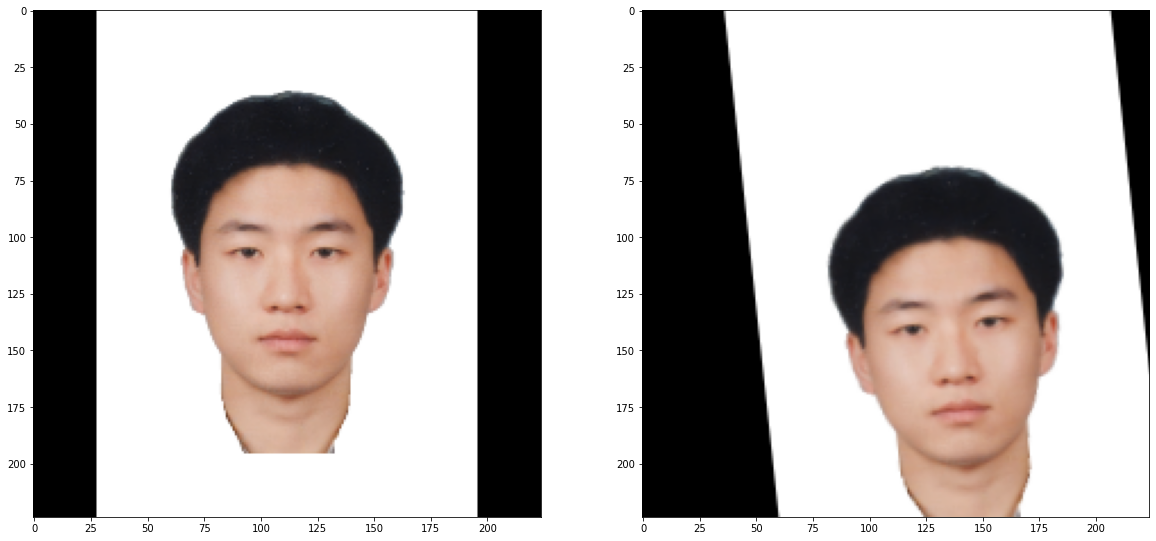

In [ ]:
%matplotlib inline 

tmp = df_hair_data.loc[df_hair_data['file_name'] == '98']

plt.figure(figsize=(20,20))

for i in range(2):

    plt.subplot(1, 2, i + 1)
    plt.imshow(tmp['image'].iloc[i], cmap=plt.cm.gray)

plt.show()